# Data Exploration and cleaning

In [838]:
import pandas as pd   
import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline        
import seaborn as sns

In [839]:
data_values = pd.read_csv('csv_data/Training_set_values.csv')
data_labels = pd.read_csv('csv_data/Training_set_labels.csv')

In [840]:
data_values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [841]:
data_labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [842]:
data_values.set_index('id',inplace=True)

In [843]:
data_labels.set_index('id',inplace=True)

>- Afrter exploting the outer and inner merge, decided there's the same number of entries with the same id number as primary key 

In [844]:
final_data = data_values.merge(data_labels, on ='id')

In [845]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [846]:
final_data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [847]:
final_data.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

# Source

After exploring the Source, source_class and source_type, I decided to keep only source as it has more details to source_type and the same information with different classification under source_class

In [848]:
final_data.source.value_counts()

source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: count, dtype: int64

In [849]:
final_data.source_type.value_counts()

source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: count, dtype: int64

In [850]:
final_data.source_class.value_counts()

source_class
groundwater    45794
surface        13328
unknown          278
Name: count, dtype: int64

In [851]:
final_data.groupby(['source_class','source']).count()

amount_tsh  date_recorded  funder  \
source_class source                                                    
groundwater  hand dtw                     874            874     868   
             machine dbh                11075          11075   10251   
             shallow well               16824          16824   16301   
             spring                     17021          17021   15870   
surface      dam                          656            656     647   
             lake                         765            765     763   
             rainwater harvesting        2295           2295    2099   
             river                       9612           9612    8715   
unknown      other                        212            212     204   
             unknown                       66             66      45   

                                   gps_height  installer  longitude  latitude  \
source_class source                                                             
groundwater  hand dtw                     874        868        874       874   
             machine dbh                11075      10246      11075     11075   
             shallow well               16824      16286      16824     16824   
             spring                     17021      15870      17021     17021   
surface      dam                          656        646        656       656   
             lake                         765        762        765       765   
             rainwater harvesting        2295       2096       2295      2295   
             river                       9612       8721       9612      9612   
unknown      other                        212        204        212       212   
             unknown                       66         46         66        66   

                                   wpt_name  num_private  basin  ...  payment  \
source_class source                                              ...            
groundwater  hand dtw                   874          874    874  ...      874   
             machine dbh              11074        11075  11075  ...    11075   
             shallow well             16824        16824  16824  ...    16824   
             spring                   17020        17021  17021  ...    17021   
surface      dam                        656          656    656  ...      656   
             lake                       765          765    765  ...      765   
             rainwater harvesting      2295         2295   2295  ...     2295   
             river                     9612         9612   9612  ...     9612   
unknown      other                      212          212    212  ...      212   
             unknown                     66           66     66  ...       66   

                                   payment_type  water_quality  quality_group  \
source_class source                                                             
groundwater  hand dtw                       874            874            874   
             machine dbh                  11075          11075          11075   
             shallow well                 16824          16824          16824   
             spring                       17021          17021          17021   
surface      dam                            656            656            656   
             lake                           765            765            765   
             rainwater harvesting          2295           2295           2295   
             river                         9612           9612           9612   
unknown      other                          212            212            212   
             unknown                         66             66             66   

                                   quantity  quantity_group  source_type  \
source_class source                                                        
groundwater  hand dtw                   874             874          874   
             machine db

In [852]:
final_data = final_data.drop(['source_type', 'source_class'], axis=1)

# Waterpoint type
>- Both waterpoint_type and waterpoint_type group have the same information and I'm dropiing waterpoint_type as waterpoint_type_group has better representation of the values with no duplicate entries. Value communal standpipe and communal standpipe multiple represent the same thing. 

In [853]:
final_data.waterpoint_type.value_counts()

waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: count, dtype: int64

In [854]:
final_data.waterpoint_type_group.value_counts()

waterpoint_type_group
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: count, dtype: int64

In [855]:
final_data = final_data.drop(['waterpoint_type'], axis=1)

# Water quality and quantity
>- Keeping quality_group column as the state of abondanment doesn't seem a factor of water quality that needs it's own entry, and good sounds like a good major of quality than soft water.
>- Quality and quality_group columns have the same data and dropping quality.

In [856]:
final_data.water_quality.value_counts()

water_quality
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: count, dtype: int64

In [857]:
final_data.quality_group.value_counts()

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: count, dtype: int64

In [858]:
final_data.quantity.value_counts()

quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [859]:
final_data.quantity_group.value_counts()

quantity_group
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [860]:
final_data = final_data.drop(['quantity', 'water_quality'], axis=1)

# Managment and Payment 
>- Managment and managment groups convey the same information with the same number of entries, I decided to keep the managment group and drop managment_group as it has more information that specifically call the industry, especially given that VWC has majority of the water pump entries.
>- Payment_type and payment have the same information and decided to drop payment and keep payment_type.

In [861]:
final_data.management.value_counts()

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

In [862]:
final_data.management_group.value_counts()

management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: count, dtype: int64

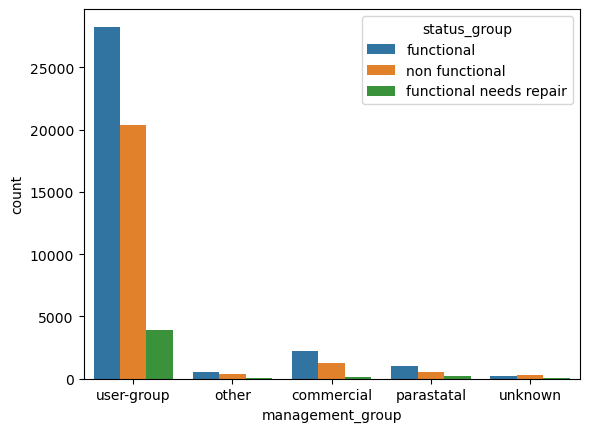

In [863]:
ax = sns.countplot(x='management_group', hue="status_group", data=final_data)

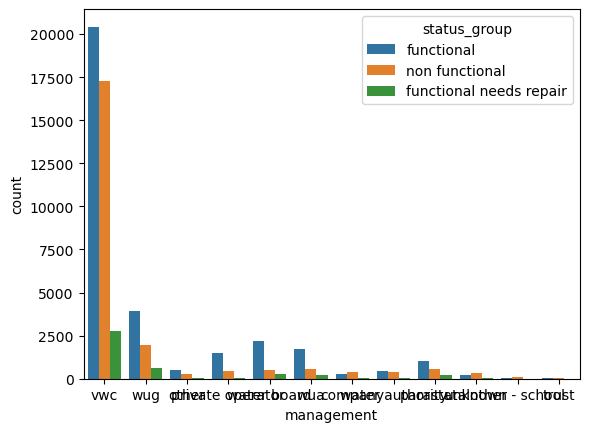

In [864]:
ax = sns.countplot(x='management', hue="status_group", data=final_data)

In [865]:
final_data.groupby(['management_group','management']).count()

amount_tsh  date_recorded  funder  \
management_group management                                            
commercial       company                  685            685     663   
                 private operator        1971           1971    1957   
                 trust                     78             78      78   
                 water authority          904            904     836   
other            other                    844            844     837   
                 other - school            99             99      99   
parastatal       parastatal              1768           1768    1624   
unknown          unknown                  561            561     533   
user-group       vwc                    40507          40507   37630   
                 water board             2933           2933    2715   
                 wua                     2535           2535    2308   
                 wug                     6515           6515    6483   

                                   gps_height  installer  longitude  latitude  \
management_group management                                                     
commercial       company                  685        663        685       685   
                 private operator        1971       1959       1971      1971   
                 trust                     78         78         78        78   
                 water authority          904        836        904       904   
other            other                    844        831        844       844   
                 other - school            99         99         99        99   
parastatal       parastatal              1768       1626       1768      1768   
unknown          unknown                  561        527        561       561   
user-group       vwc                    40507      37630      40507     40507   
                 water board             2933       2714       2933      2933   
                 wua                     2535       2309       2535      2535   
                 wug                     6515       6473       6515      6515   

                                   wpt_name  num_private  basin  ...  \
management_group management                                      ...   
commercial       company                685          685    685  ...   
                 private operator      1971         1971   1971  ...   
                 trust                   78           78     78  ...   
                 water authority        904          904    904  ...   
other            other                  844          844    844  ...   
                 other - school          99           99     99  ...   
parastatal       parastatal            1768         1768   1768  ...   
unknown          unknown                561          561    561  ...   
user-group       vwc                  40507        40507  40507  ...   
                 water board           2932         2933   2933  ...   
                 wua                   2535         2535   2535  ...   
                 wug                   6514         6515   6515  ...   

                                   extraction_type  extraction_type_group  \
management_group management                                                 
commercial       company                       685                    685   
                 private operator             1971                   1971   
                 trust                          78                     78   
                 water authority               904                    904   
other            other                         844                    844   
                 other - school                 99                     99   
parastatal       parastatal                   1768                   1768   
unknown          unknown                       561                    561   
user-group       vwc                         40507                  40507   
                 water board       

In [866]:
final_data.payment.value_counts()

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: count, dtype: int64

In [867]:
final_data.payment_type.value_counts()

payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: count, dtype: int64

In [868]:
final_data = final_data.drop(['payment', 'management_group'], axis=1)

# Extraction
>- Extraction_type, Extraction_type_group, and extraction_type_class have the same information about the type of extraction. Decided to drop the detailed different types of extraction and instead use the method of class. extraction_type_class

In [869]:
final_data.extraction_type.value_counts()

extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: count, dtype: int64

In [870]:
final_data.extraction_type_group.value_counts()

extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: count, dtype: int64

In [871]:
final_data.extraction_type_class.value_counts()

extraction_type_class
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: count, dtype: int64

In [872]:
final_data.groupby(['extraction_type_class','extraction_type', 'extraction_type_group']).count()

amount_tsh  \
extraction_type_class extraction_type           extraction_type_group               
gravity               gravity                   gravity                     26780   
handpump              afridev                   afridev                      1770   
                      india mark ii             india mark ii                2400   
                      india mark iii            india mark iii                 98   
                      nira/tanira               nira/tanira                  8154   
                      other - mkulima/shinyanga other handpump                  2   
                      other - play pump         other handpump                 85   
                      other - swn 81            other handpump                229   
                      swn 80                    swn 80                       3670   
                      walimi                    other handpump                 48   
motorpump             cemo                      other motorpump                90   
                      climax                    other motorpump                32   
                      mono                      mono                         2865   
other                 other                     other                        6430   
rope pump             other - rope pump         rope pump                     451   
submersible           ksb                       submersible                  1415   
                      submersible               submersible                  4764   
wind-powered          windmill                  wind-powered                  117   

                                                                       date_recorded  \
extraction_type_class extraction_type           extraction_type_group                  
gravity               gravity                   gravity                        26780   
handpump              afridev                   afridev                         1770   
                      india mark ii             india mark ii                   2400   
                      india mark iii            india mark iii                    98   
                      nira/tanira               nira/tanira                     8154   
                      other - mkulima/shinyanga other handpump                     2   
                      other - play pump         other handpump                    85   
                      other - swn 81            other handpump                   229   
                      swn 80                    swn 80                          3670   
                      walimi                    other handpump                    48   
motorpump             cemo                      other motorpump                   90   
                      climax                    other motorpump                   32   
                      mono                      mono                            2865   
other                 other                     other                           6430   
rope pump             other - rope pump         rope pump                        451   
submersible           ksb                       submersible                     1415   
                      submersible               submersible                     4764   
wind-powered          windmill                  wind-powered                     117   

                                                                       funder  \
extraction_type_class extraction_type           extraction_type_group           
gravity               gravity                   gravity                 24704   
handpump              afridev                   afridev                  1668   
                      india mark ii             india mark ii            2358   
                      india mark iii            india mark iii             98   
                      nira/tanira               nira/tanira              7899   
                      other - mkulima/shin

In [873]:
final_data = final_data.drop(['extraction_type_group', 'extraction_type'], axis=1)

# Recorded_by, scheme managment, name and managment 
>- we  kept the managment column above but there's another column with similar information. I decided to drop managment since scheme managment has a cleaned representation of the values, other is repeated twice in managment foe example.
>- Scheme name doesn't seem like it has correlation or any valuable insight towards functionality of a pump so I decided to drop it as well.
>- There's only one type of entry in recorded_by which means there's no effect from having it so will also drop this column.

In [874]:
final_data.recorded_by.value_counts()

recorded_by
GeoData Consultants Ltd    59400
Name: count, dtype: int64

In [875]:
final_data.scheme_management.value_counts()

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [876]:
final_data.management.value_counts()

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

In [877]:
final_data.scheme_name.value_counts()

scheme_name
K                       682
Borehole                546
Chalinze wate           405
M                       400
DANIDA                  379
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: count, Length: 2695, dtype: int64

In [ ]:
ax = sns.countplot(x='scheme_name', hue="status_group", data=final_data) #Not a usefull measure of functionality

In [ ]:
final_data = final_data.drop(['management', 'scheme_name', 'recorded_by'], axis=1)

# Population, Public meeting and permit
>- Public meeting and permit being true seems to have higher functional pumps than those operating without permit and don't have meetings.

In [ ]:
final_data.public_meeting.value_counts() 

In [ ]:
ax = sns.countplot(x='public_meeting', hue="status_group", data=final_data)

In [ ]:
final_data.permit.value_counts()

In [ ]:
ax = sns.countplot(x='permit', hue="status_group", data=final_data)

In [ ]:
ax = sns.countplot(x='amount_tsh', hue="status_group", data=final_data)

In [ ]:
plt.scatter(final_data['amount_tsh'], final_data['population'])
plt.xlabel('Amount TSH')
plt.ylabel('Population')
plt.title('Relationship between Amount TSH and Population')
plt.show()

In [ ]:
final_data.info()

# Locations 
>- Dropping subvillage, region_code,lga and ward since they include geographical locations that is grouped better under region. District_code has the same values for different regions and decided to drop it to prevent ambiguity. 
>- we also have latitude and longtitude that can give us precise location instead names, to calculate water source distance and other locational factors that can affect a water pump's functionality
>- num_private doesn't have any description from data source dropping it since it's unclear what the numeric variable represents 

In [ ]:
final_data.district_code.value_counts()

In [ ]:
final_data.num_private.value_counts()

In [ ]:
ax = sns.countplot(x='region', hue="status_group", data=final_data)

In [ ]:
final_data.groupby(['subvillage', 'lga', 'ward']).count().head()

In [ ]:
final_data.groupby(['region','region_code', 'district_code']).count().head()

In [ ]:
final_data = final_data.drop(['district_code', 'region_code', 'lga','ward', 'num_private','subvillage'], axis=1)

In [ ]:
final_data.isna().sum()

# Other Columns to drop
>- wpt_name, having a unique identifier ID should be good enough and name isn't a factor affecting functionality
>- Region doesn't seem to have much correlation to functionality as we saw above and dropping it
>- 

In [ ]:
final_data.installer.value_counts()

In [ ]:
final_data.funder.value_counts()

In [ ]:
final_data = final_data.drop(['wpt_name', 'region'], axis=1)

# Filling/ missing values
>- filling contrsuction year with the mean
>- filling with unknown for empty data in permit and public meeting
>- Replacing most frequent data to unknown value

In [ ]:
final_data.isna().sum()

In [ ]:
final_data.info()

In [ ]:
final_data.loc[final_data['construction_year']!=0].describe()

In [ ]:
final_data['construction_year'].replace(to_replace = 0, value = 2000, inplace=True)

# Ternary target
>- Functional = 2
>- Functional needs repaire = 1
>- Non functional = 0

In [ ]:
vals_to_replace = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

final_data['status_group']  = final_data.status_group.replace(vals_to_replace)

In [ ]:
final_data.isna().sum()

In [ ]:
final_data.permit = final_data.permit.fillna('Unknown')
most_frequent_permit = final_data.permit.mode()[0]
final_data.permit = final_data.permit.replace('Unknown', most_frequent_permit)

In [ ]:
final_data.public_meeting = final_data.public_meeting.fillna('Unknown')
most_frequent_meeting = final_data.public_meeting.mode()[0]
final_data.public_meeting = final_data.public_meeting.replace('Unknown', most_frequent_meeting)

In [ ]:
final_data.installer = final_data.installer.fillna('Unknown')
most_frequent_installer = final_data.installer.mode()[0]
final_data.installer = final_data.installer.replace('Unknown', most_frequent_installer)

In [ ]:
final_data.funder = final_data.funder.fillna('Unknown')
most_frequent_funder = final_data.funder.mode()[0]
final_data.funder = final_data.funder.replace('Unknown', most_frequent_funder)

In [ ]:
final_data.scheme_management = final_data.scheme_management.fillna('Unknown')
most_frequent_managment = final_data.scheme_management.mode()[0]
final_data.scheme_management = final_data.scheme_management.replace('Unknown', most_frequent_managment)

In [ ]:
final_data.info()

In [ ]:
ax = sns.countplot(x='waterpoint_type_group', hue="status_group", data=final_data)

In [ ]:
final_data.installer.value_counts()

# Keeping the top 5 and assigning the rest to other for categorical columns that have a long list

In [ ]:
final_data.scheme_management.value_counts()

In [ ]:
final_data['scheme_management'] = final_data['scheme_management'].replace(
    ['Private operator', 'Company', 'Other', 'WUA', 'SWC', 'Trust', 'Parastatal'], 'other'
)

final_data['scheme_management'] = final_data['scheme_management']

In [ ]:
final_data.scheme_management.value_counts()

In [ ]:
final_data['funder'].value_counts()

In [ ]:
def funder_cleaned(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    top_values = ['Government Of Tanzania', 'Danida', 'Hesawa', 'Rwssp', 'World Bank']
    if row['funder'] in top_values:
        return row['funder']
    else:
        return 'other'

final_data['funder'] = final_data.apply(funder_cleaned, axis=1)

In [ ]:
def installer_cleaned(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    top_values = ['DWE', 'Government', 'RWE', 'Commu', 'DANIDA']
    if row['installer'] in top_values:
        return row['installer']
    else:
        return 'other'

final_data['installer'] = final_data.apply(installer_cleaned, axis=1)

In [ ]:
final_data.installer.value_counts()

In [ ]:
final_data = final_data.drop(['date_recorded'], axis=1)

In [ ]:
final_data.info()

In [ ]:
final_data.to_csv('tz_data.csv')